In [1]:
import transportation_tutorials as tt

# Manipulating Geographic Data

A [shapefile](https://en.wikipedia.org/wiki/Shapefile) is a data format that is actually a set of files
containing geospatial information.  All of the related files have the same filename (except for the file
extension) and must reside in the same directory.  Generally, there will be files with the ``shp`` extension 
containing geographic data, the ``dbf`` extension containing tabular data, and a few others.  The files
can be read into python as a group and manipulated using the [GeoPandas](http://geopandas.org) package.

In [2]:
import geopandas as gpd

## Loading a Shapefile

Let's load the SERPM8 TAZ shapefile.  This shapefile (actually a set of files)
is included in the data of the tuturials package and can be accessed as shown.
Loading a shapefile into Python using geopandas is a simple task using the
[read_file](http://geopandas.org/reference/geopandas.read_file.html) function.

In [3]:
shapefile_filename = tt.data('SERPM8-TAZSHAPE')
taz = gpd.read_file(shapefile_filename)

This will load the shapefile into a 
[GeoDataFrame](http://geopandas.org/reference.html#geodataframe) object, 
which is similar to
a pandas DataFrame, but with a special *geometry* column that contains, 
as you might guess, geometric shape data contained in the *shp* part of 
the shapefile.  It also includes all the other
various tabular data contained in the *dbf* part of the shapefile.  We
can inspect the first few lines of the GeoDataFrame to see the contents,
just like a regular DataFrame:

In [4]:
taz.head()

,OBJECTID,TAZ_REG,TAZ_OLD05,TAZ_MPO,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,1,1122.0,1122,1122,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936374.674 959539.568, 936373.444 95..."
1,2,17.0,17,17,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942254.500 952920.937, 942255.812 95..."
2,3,1123.0,1123,1123,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((940953.561 952985.069, 940953.437 95..."
3,4,1120.0,1120,1120,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06,"POLYGON ((953119.000 951985.375, 953045.807 95..."
4,5,1121.0,1121,1121,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07,"POLYGON ((934328.283 951600.585, 934327.451 94..."


Because this is the TAZ shapefile, we expect that the geometry column includes a set of 
[Polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) values, as we
can observe in the first few rows.  We can also easily check how many zones are included
in the file by checking the length of the GeoDataFrame.

In [5]:
taz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4236 entries, 0 to 4235
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4236 non-null   int64   
 1   TAZ_REG     4236 non-null   float64 
 2   TAZ_OLD05   4236 non-null   int64   
 3   TAZ_MPO     4236 non-null   int64   
 4   COUNTY      4236 non-null   float64 
 5   CENSUSTAZ   1506 non-null   object  
 6   TAZ_BF      4236 non-null   int64   
 7   FIX         4236 non-null   int64   
 8   AREA        4236 non-null   float64 
 9   F_NETAREA   4236 non-null   float64 
 10  CBD         4236 non-null   int64   
 11  HM_ROOMS    4236 non-null   int64   
 12  Shape_Leng  4236 non-null   float64 
 13  Shape_Area  4236 non-null   float64 
 14  geometry    4236 non-null   geometry
dtypes: float64(6), geometry(1), int64(7), object(1)
memory usage: 496.5+ KB


Displaying the shapefile in a jupyter notebook can be accomplished by calling the 
[plot](http://geopandas.org/reference.html?highlight=plot#geopandas.GeoDataFrame.plot)
method of the GeoDataFrame.

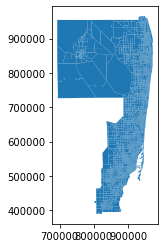

In [6]:
ax = taz.plot()

## Coordinate Reference Systems

You might notice that the axis labels don't show latitude and longitude.
That's because the TAZ file uses a 
different coordinate reference system (*crs*) for map projection.
We can find what crs is being used by accessing the [crs](http://geopandas.org/projections.html#coordinate-reference-systems) attribute.

In [7]:
taz.crs

<Projected CRS: PROJCS["NAD83 / Florida East (ftUS)",GEOGCS["NAD83 ...>
Name: NAD83 / Florida East (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Drop that code into [Google](http://www.google.com/search?q=epsg%3A2236)
and you'll find that it's a special coordinate system for
[mapping and engineering in eastern Florida](https://spatialreference.org/ref/epsg/nad83-florida-east-ftus/), which for this application may be perfectly reasonable.
However, suppose we want to generate maps using plain old 
latitude and longitude. We can convert between CRS systems
easily, like this:

In [8]:
taz1 = taz.to_crs(epsg=4326)

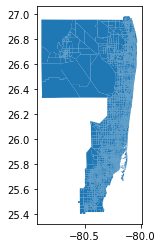

In [9]:
ax = taz1.plot()

The map projection generated here is subtly different from the previous one.  If you look
carefully, you'll note the shape of the second map is a bit wider than first.  This distortion
is a natural part of the mapping projection, using plain latitude and longitude, as one
degree of longitude is a different distance than one degree of latitude.  In Florida, the 
difference is relatively small, but it grows as you move north.

## Selecting by Geography

The SERPM8 region is quite large.  Let's suppose we only want to study a small
portion of this region. Since we are working with Jupyter notebooks, we'll select 
an area to study around Jupiter, Florida. 

### Selection by Rectangular Envelope

We can explicitly define some bounds for
our study area:

In [10]:
xmin = 905712.145924
ymin = 905343.94408855
xmax = 983346.68922847
ymax = 981695.93140023

Then, to select only the TAZ's that are (at least partially) contained in the study area,
we can use the ``cx`` indexer on GeoDataFrames.  This indexer works similarly to the ``loc``
and ``iloc`` indexers on regular DataFrames, but selects not based on labels or tabular
position, but instead selects based on geographic position.

In [11]:
taz_jupiter = taz.cx[xmin:xmax, ymin:ymax]

The result of the selection is another GeoDataFrame, just as slicing
using the ``loc``and ``iloc`` indexers on regular DataFrames creates
a new DataFrame.  Thus, we can review how many TAZ's are in the selection 
in the same manner as we checked the number of TAZ's in the original shapefile.

In [12]:
len(taz_jupiter)

220

And we can plot a map of the selected area, just as we did with 
the original data. Here, we'll draw the borders of the TAZ's in 
white for better contrast.

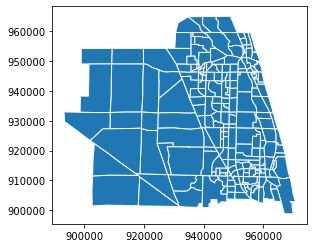

In [13]:
ax = taz_jupiter.plot(edgecolor='w')

Because Jupiter is in the northwest corner of the SERPM region, 
only the south and west boundaries of the study area are relevant
in the selection definition.  Convenietly, just like other DataFrame
indexers, the ``cx`` indexer allows for one-sided slices.

In [14]:
taz_jupiter2 = taz.cx[xmin:, ymin:]
taz_jupiter2.equals(taz_jupiter)

True

One important note regarding the ``cx`` indexer is that it will 
select all features that are contained fully *or partially* in
the selection area.  To illustrate, we can construct a GeoDataFrame
consisting of the study area box, and draw it on a map of the 
selected zones.

In [15]:
from shapely.geometry import box
from pyproj import CRS
study_area = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=CRS.from_epsg(2236))

In [16]:
study_area

,geometry
0,"POLYGON ((983346.689 905343.944, 983346.689 98..."


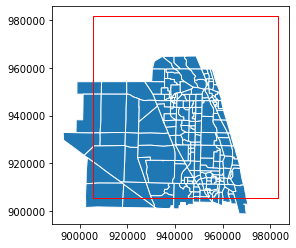

In [17]:
ax = taz_jupiter.plot(edgecolor='w')
transparent = (0,0,0,0)
ax = study_area.plot(ax=ax, edgecolor='red', facecolor=transparent)

### Selection by Polygon

If the study area is not neatly defined by a rectangle but instead by some
defined irregular polygon, it is still possible to filter the GeoDataFrame,
but slightly more complicated.  We'll demonstrate by first constructing
an irregular polygon.

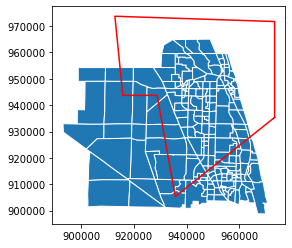

In [18]:
from shapely.geometry import Polygon
irregular_polygon = Polygon([
    (973346, 935343),
    (973346, 971695), 
    (912812, 973695), 
    (915812, 943695),  
    (928812, 943695),  
    (935712, 905343),  
])
ax = taz_jupiter.plot(edgecolor='w')
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

To indentify those TAZ polygons that touch the polygon, we can use the 
``intersects`` method of GeoDataFrames.

In [19]:
taz_jupiter.intersects(irregular_polygon)

0       True
1       True
2       True
3       True
4       True
        ... 
1641    True
1642    True
1643    True
1644    True
1645    True
Length: 220, dtype: bool

In [20]:
taz_jupiter

,OBJECTID,TAZ_REG,TAZ_OLD05,TAZ_MPO,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,1,1122.0,1122,1122,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936374.674 959539.568, 936373.444 95..."
1,2,17.0,17,17,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942254.500 952920.937, 942255.812 95..."
2,3,1123.0,1123,1123,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((940953.561 952985.069, 940953.437 95..."
3,4,1120.0,1120,1120,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06,"POLYGON ((953119.000 951985.375, 953045.807 95..."
4,5,1121.0,1121,1121,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07,"POLYGON ((934328.283 951600.585, 934327.451 94..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,1642,1571.0,1571,1571,1.0,None,0,0,2175400.0,0.8139,0,0,8175.287650,2.175399e+06,"POLYGON ((948645.617 938369.478, 948477.396 93..."
1642,1643,41.0,41,41,1.0,None,0,0,3112200.0,0.8035,0,0,7365.584371,3.112197e+06,"POLYGON ((948260.308 941116.742, 948033.694 94..."
1643,1644,25.0,25,25,1.0,None,0,0,16108500.0,0.9281,0,0,18997.481697,1.610847e+07,"POLYGON ((942059.220 931753.801, 942017.697 93..."
1644,1645,1569.0,1569,1569,1.0,None,0,0,7811080.0,1.0000,0,0,11310.786358,7.811077e+06,"POLYGON ((944289.070 933071.090, 944242.356 93..."


This gives us a series that matches the GeoDataFrame, and identifies whether
each row's geometry intersects the the polygon.  We can use that to filter
the rows, to retain only those TAZ's of interest.

In [21]:
taz_jupiter_irregular = taz_jupiter[taz_jupiter.intersects(irregular_polygon)]

In [22]:
len(taz_jupiter_irregular)

146

This gives us a new GeoDataFrame that is potentially just a filtered view of the 
original, which can potentially lead to problems later ([see here](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy)).  To ensure we have a
bonafide new GeoDataFrame, we can make sure it is a copy.

In [23]:
taz_jupiter_irregular = taz_jupiter_irregular.copy()

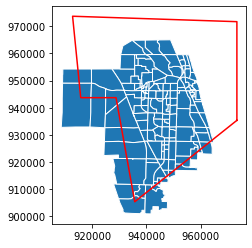

In [24]:
ax = taz_jupiter_irregular.plot(edgecolor='w')
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

You may note, as with the rectangular selection, we still select any 
zone that has any part of the zone inside the polygon.

## Clipping by Geography

If instead we want to actually clip the geographic data at the study area frame,
we can use the ``overlay`` function to get the intersection of the TAZ's and the
study area.

In [25]:
taz_jupiter_clip = gpd.overlay(taz, study_area.to_crs(taz.crs), how='intersection')

By taking the intersection, we discard portions of the zone shapes that
are outside the study area, as is illustrated when we map the results
with the study area box.

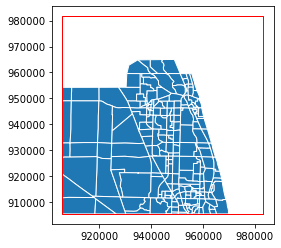

In [26]:
ax = taz_jupiter_clip.plot(edgecolor='w')
transparent = (0,0,0,0)
ax = study_area.plot(ax=ax, edgecolor='red', facecolor=transparent)

Alternatively, if we have a polygon, we can use ``intersection`` to trim the GeoDataFrame
geometry to only the overlapping areas.

In [27]:
taz_jupiter_irregular.geometry = taz_jupiter_irregular.intersection(irregular_polygon)

In [28]:
taz_jupiter_irregular

,OBJECTID,TAZ_REG,TAZ_OLD05,TAZ_MPO,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,1,1122.0,1122,1122,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936373.444 958211.473, 936985.437 95..."
1,2,17.0,17,17,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942255.812 952648.750, 942256.500 95..."
2,3,1123.0,1123,1123,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((940953.437 952905.027, 938308.351 95..."
3,4,1120.0,1120,1120,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06,"POLYGON ((953045.807 952005.661, 953036.379 95..."
4,5,1121.0,1121,1121,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07,"POLYGON ((934327.451 948958.968, 934225.673 94..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,1642,1571.0,1571,1571,1.0,None,0,0,2175400.0,0.8139,0,0,8175.287650,2.175399e+06,"POLYGON ((948477.396 938417.383, 948358.410 93..."
1642,1643,41.0,41,41,1.0,None,0,0,3112200.0,0.8035,0,0,7365.584371,3.112197e+06,"POLYGON ((948033.694 941108.067, 947377.033 94..."
1643,1644,25.0,25,25,1.0,None,0,0,16108500.0,0.9281,0,0,18997.481697,1.610847e+07,"POLYGON ((942017.697 931747.864, 941995.151 93..."
1644,1645,1569.0,1569,1569,1.0,None,0,0,7811080.0,1.0000,0,0,11310.786358,7.811077e+06,"POLYGON ((944242.356 933263.091, 944127.723 93..."


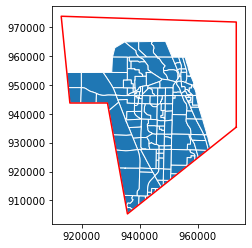

In [29]:
ax = taz_jupiter_irregular.plot(edgecolor='w')
transparent = (0,0,0,0)
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

An important feature to consider if using this method is that the operation
does not actually change the set of rows or any other data included in the 
GeoDataFrame.  If, for example, we apply it to the set of TAZ's from the square
clipped region, we can get a map that looks identical, but the GeoDataFrame will
still retain all the data rows from the previous version, just with some geometry
values set as empty.

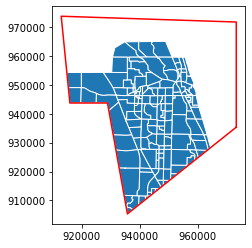

In [30]:
taz_jupiter_clip.geometry = taz_jupiter_clip.intersection(irregular_polygon)
ax = taz_jupiter_clip[taz_jupiter_clip.area > 0].plot(edgecolor='w')
transparent = (0,0,0,0)
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

In [31]:
len(taz_jupiter_irregular), len(taz_jupiter_clip)

(146, 220)

In [32]:
sum(taz_jupiter_clip.geometry.area == 0)

74

## Joining by Geography

A common task in geographic analysis is joining two sets of geographic data 
together.  We actually did a simple version of this just above, when we joined
the TAZ data with the study area, although the study area had only a single polygon
and no other associated data, so the results are not particularly inspiring.

As a more sophisticated example, let's consider the micro-area zone (MAZ) system from 
SERPM8.  The MAZ are smaller zones nested inside TAZ's, used to provide a higher resolution of data, 
particularly for transit travel. Using the TAZ system is sometimes too coarse for 
this purpose, as it may be convenient to walk to a bus stop located on a TAZ boundary
only for some parts of the zone, while the walking from the far side of the
same TAZ to the bus stop might be unreasonably far.  

Like the TAZ system, the MAZ system for SERPM8 is given by a shape file, and is included
in the tutorial data, so we can load it in the same way.

In [33]:
mazshape_filename = tt.data('SERPM8-MAZSHAPE')
maz = gpd.read_file(mazshape_filename)

In [34]:
len(maz)

12022

In [35]:
maz.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,"POLYGON ((953970.466 723936.081, 953972.382 72..."
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,"POLYGON ((908505.280 635081.774, 908488.945 63..."
2,3,5349,9446.131753,4.007041e+06,92,923725,707062,"POLYGON ((922736.637 708387.692, 923950.960 70..."
3,4,5350,21773.153739,2.487397e+07,571,908988,713484,"POLYGON ((908334.237 715692.263, 908714.653 71..."
4,5,5351,17882.701416,1.963139e+07,451,909221,717493,"POLYGON ((911883.019 719309.326, 911940.995 71..."


<AxesSubplot:>

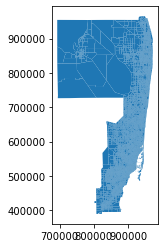

In [36]:
maz.plot()

We can select only MAZ's in the study area in the same manner as we did for TAZ's.

In [37]:
maz_jupiter = maz.cx[xmin:xmax, ymin:ymax]

In [38]:
len(maz_jupiter)

361

To create a joined GeoDataFrame, we can use the same [``overlay``](http://geopandas.org/reference/geopandas.overlay.html) function we used to clip
the TAZ's, although we will intersect the TAZ and MAZ geometries.

In [39]:
maz_taz = gpd.overlay(maz_jupiter, taz_jupiter, how='intersection')

The joined GeoDataFrame has all the columns from both the MAZ and TAZ source data.  In cases
where both source tables have an identically named column (for example, "OBJECTID") then both 
columns are retained, and they are labeled with "\_1" and "\_2" suffixes.

In [40]:
maz_taz.head()

,OBJECTID_1,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,OBJECTID_2,TAZ_REG,TAZ_OLD05,...,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,2389,7736,10592.846522,4.442490e+06,102,936259,957308,1,1122.0,1122,...,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936373.444 958211.473, 936985.437 95..."
1,2391,7738,18511.806088,1.405994e+07,323,937715,953796,3,1123.0,1123,...,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((938072.285 952651.635, 937929.056 95..."
2,6329,11676,10422.047410,3.336191e+06,77,937781,950989,3,1123.0,1123,...,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((938316.202 951630.563, 938211.071 95..."
3,3052,8399,23965.014606,3.096111e+07,711,934758,961537,664,1105.0,1105,...,None,0,0,30961100.0,0.8148,0,0,23965.014606,3.096111e+07,"POLYGON ((938616.375 961787.437, 938675.000 96..."
4,3053,8400,21094.345933,2.778533e+07,638,933039,956882,665,1106.0,1106,...,None,0,0,27785300.0,0.9483,0,0,21094.345933,2.778533e+07,"POLYGON ((935662.121 956689.687, 935660.751 95..."


Because we know that the MAZ's are supposed to be nested within the TAZ's, we
would normally expect that the joined data would have exactly one row for each of the
361 MAZ's, and that some TAZ's would be duplicated.  However, that's not what has happened.

In [41]:
len(maz_taz)

437

### Managing Errors in Joining Spatial Data

The joined data has 564 new zones, 203 more than we expected.  There are two
reasons for this discrepancy, although both are a result of the two zone systems
being misaligned.

The first reason is related to the limits computer precision: some of the new 
zones are merely slivers of space that arise due to rounding errors on the
computer placement of vertices.  If we evaluate the area of the first 5 zones
in the joined data table, we see that one of the zones is only 1.878×10<sup>-3</sup> 
square feet, or about a quarter of a square inch.
Clearly, this isn't a real zone!

In [42]:
maz_taz.head().area

0    4.442490e+06
1    1.405994e+07
2    3.336191e+06
3    3.096111e+07
4    2.778533e+07
dtype: float64

The seconds reason that extra zones are found in this join is because the two
zone systems are not always carefully aligned by the analysts who originally drew 
the zones, particularly in areas that are not functionally important. 
For example, here are the boundaries for the TAZ and MAZ systems, superimposed over 
a map of the The Loxahatchee Club golf course in Jupiter.  

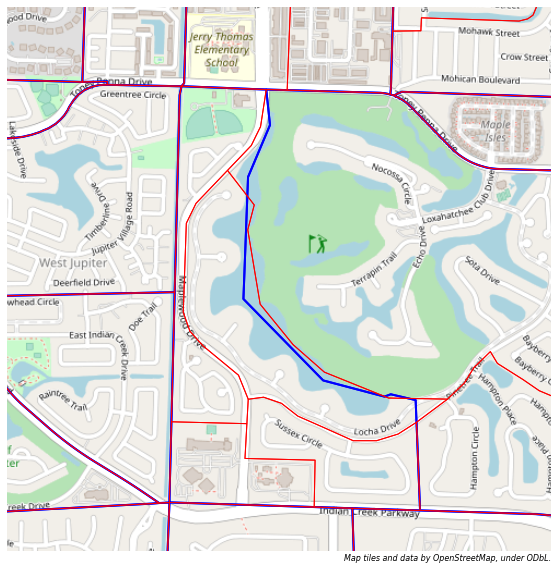

In [43]:
ax = tt.mapping.make_basemap(xlim=(938500,945500), ylim=(937500,944500), zoom=15, 
                             tiles=tt.mapping.providers.OpenStreetMap.Mapnik.url, epsg=2236, axis='off')
ax = taz_jupiter.plot(ax=ax, edgecolor='blue', linewidth=2, facecolor=transparent )
ax = maz_jupiter.plot(ax=ax, edgecolor='red', linewidth=1, facecolor=transparent )

When the intersection of the two zone systems is computed, half a dozen extraneous small zones 
are generated along the lake that forms the western edge of the golf course, but these are not
actually meaningful activity locations and are not relevant for transortation analysis.

The possible solutions to both problems are the same, given that we know that the "correct" join solution
will have exactly one zone in the result for each MAZ.

#### Dropping Extra Pieces

One possible solution is to take the joined data we already have, and remove all 
the extra pieces of zones that were created, retaining only the largest main 
section of each MAZ.
To do this, we can sort zones in the joined GeoDataFrame by area, 
and retain only the largest zone from each group of duplicated MAZ codes.

First, we'll use the argsort method, to get the order of the joined zones, if ordered
by area.  Then we feed that into the ``iloc`` indexer to actually sort the rows as
indicated.  The argsort returns values in ascending order by default, so all the small
slivers and bits of zones we want to discard will appear first.

In [44]:
maz_taz = maz_taz.iloc[maz_taz.area.argsort()] 

Then, we can drop duplicate MAZ values from the table, keeping only the last instance
of each MAZ, which is the one we want.  In theory, if the two zones systems are very poorly
aligned, this process could drop the wrong part of the zones, although in almost all 
cases it will work fine.

In [45]:
maz_taz = maz_taz.drop_duplicates('MAZ', keep='last')

In [46]:
len(maz_taz)

361

One drawback of this method is that some small gaps may be left in the resulting
joined GeoDataFrame zones, in the spaces that are removed, as illustrated below.  
This may or may not be problematic, depending on the application.

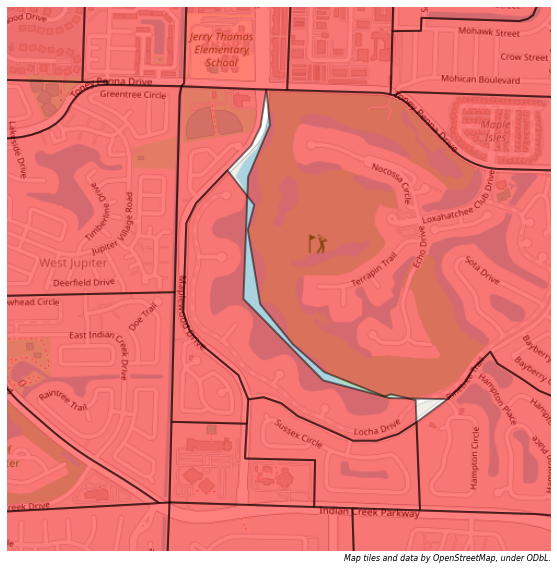

In [47]:
ax = tt.mapping.make_basemap(xlim=(938500,945500), ylim=(937500,944500), zoom=15, 
                             tiles=tt.mapping.providers.OpenStreetMap.Mapnik.url, epsg=2236, axis='off')
ax = maz_taz.plot(ax=ax, edgecolor='k', linewidth=2, facecolor='r', alpha=0.5 )

#### Joining on Centroids

An alternate solution is to join the TAZ and MAZ data in a entirely different manner.
Rather than joining the two GeoDataFrames based on the area polygons in each, we
can join based on the area polygons for TAZ's and centroids for MAZ's.
To do this, we'll use the [sjoin](http://geopandas.org/reference/geopandas.sjoin.html)
method.

First, we'll need a version of the MAZ GeoDataFrame that has only centroid points
in the `geometry` column, instead of polygons.  To create this, start by making a copy of the
original data (assuming we want to save it for later).

In [48]:
maz_points = maz_jupiter.copy()

Then we want to change the geometry to be points instead of polygons.
(Both [Point](https://shapely.readthedocs.io/en/stable/manual.html#points) 
and [Polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) 
are specific object types in the shapely package that is used by GeoPandas.)
We could simply use the 'centroid' attribute of the geometry column to find new centroid 
for each zone, but in this data we already have X and Y values for a centroid,
so we'll prefer to use those.  We can uses the [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method of DataFrames 
to create Point values, and assign those values into the geometry column.

In [49]:
from shapely.geometry import Point
maz_points.geometry = maz_points.apply(lambda x: Point(x.POINT_X, x.POINT_Y), axis=1)

Now we are ready to conduct a spatial join using the
[sjoin](http://geopandas.org/reference/geopandas.sjoin.html) function.
Like the overlay function, this function accepts two GeoDataFrames and returns
one, with general data columns from both inputs.  
Unlike the overlay function, the [sjoin](http://geopandas.org/reference/geopandas.sjoin.html) does not create any new geometries; 
instead, the resulting GeoDataFrame contains geometry from either
the left (first argument) or right (second argument) input GeoDataFrames.

In [50]:
sjoined = gpd.sjoin(maz_points, taz_jupiter, how='left', op='within')

In [51]:
len(sjoined)

361

In [52]:
sjoined.head()

,OBJECTID_left,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry,index_right,OBJECTID_right,...,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area
2388,2389,7736,10592.846522,4.442490e+06,102,936259,957308,POINT (936259.000 957308.000),0,1,...,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06
2389,2390,7737,17396.297932,1.568938e+07,360,940102,950911,POINT (940102.000 950911.000),1,2,...,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07
2390,2391,7738,18511.806088,1.405994e+07,323,937715,953796,POINT (937715.000 953796.000),2,3,...,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07
2391,2392,7739,7202.864864,1.303422e+06,30,953218,953704,POINT (953218.000 953704.000),3,4,...,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06
2392,2393,7740,24940.959492,3.147748e+07,723,931973,952018,POINT (931973.000 952018.000),4,5,...,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07


The resulting GeoDataFrame has the geometry from the left input, which in this case is 
just the centroid points.

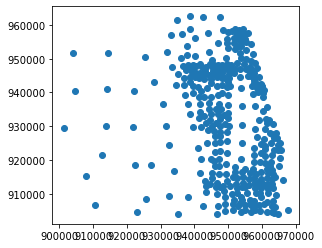

In [53]:
ax = sjoined.plot()

If we want to re-attach the polygon zones, we can do so easily if we didn't overwrite
the original MAZ data, because this joined data is in the same order as the original.

In [54]:
sjoined.MAZ.equals(maz_jupiter.MAZ)

True

In [55]:
sjoined.geometry = maz_jupiter.geometry

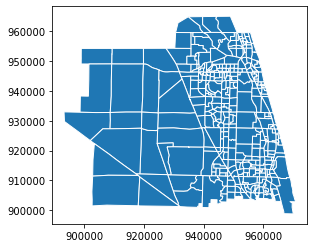

In [56]:
ax = sjoined.plot(edgecolor='w')

### Creating a Crosswalk Dictionary from the Joined Data

We will sometimes be given a MAZ id but want to get the TAZ id instead.  As this is
a one-to-many mapping (every MAZ is in one and only one TAZ, but each TAZ can contain
multiple MAZ's), it is convenient to express this mapping as a Python dictionary.
This can be done easily if the ``index`` of the GeoDataFrame is set to be the MAZ.

In [57]:
sjoined.index=sjoined.MAZ

In [58]:
maz_taz_crosswalk = dict(sjoined.TAZ_MPO)

In [59]:
maz_taz_crosswalk

{7736: 1122,
 7737: 17,
 7738: 1123,
 7739: 1120,
 7740: 1121,
 7741: 1150,
 7742: 1152,
 7743: 1140,
 7744: 44,
 7745: 1503,
 7746: 1547,
 7747: 1546,
 7748: 1103,
 7749: 1124,
 7750: 21,
 7751: 1504,
 7752: 842,
 7753: 1505,
 7754: 1506,
 7755: 1141,
 7756: 45,
 7757: 1153,
 7758: 1154,
 7759: 1155,
 7760: 59,
 7761: 1156,
 7762: 42,
 7763: 1507,
 7764: 844,
 7765: 1508,
 7766: 845,
 7767: 40,
 7768: 1138,
 7769: 38,
 7770: 1135,
 7771: 1137,
 7772: 887,
 7773: 1518,
 7774: 47,
 7775: 36,
 7776: 1134,
 7777: 1133,
 7778: 1125,
 7779: 27,
 7780: 1126,
 7781: 37,
 7782: 1136,
 7783: 1131,
 7784: 1130,
 7785: 34,
 7786: 1128,
 7787: 1129,
 7788: 1132,
 7791: 49,
 7792: 1143,
 7793: 890,
 7794: 1520,
 7795: 1519,
 7802: 1543,
 7803: 1544,
 7804: 1068,
 7805: 53,
 7806: 1127,
 7807: 1145,
 7808: 51,
 7809: 1146,
 7810: 1147,
 7811: 1148,
 7812: 1157,
 7813: 70,
 7814: 851,
 7815: 1510,
 7816: 1509,
 7817: 1161,
 7818: 88,
 7819: 89,
 7820: 1164,
 7821: 1163,
 7822: 90,
 7823: 1158,
 7824:

Then, given a MAZ number we can access the TAZ simply like this:

In [60]:
maz_number = 7755
taz_number = maz_taz_crosswalk[maz_number]